In [17]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam
from torch.nn import functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
path = '../abalone/abalone.data'
df = pd.read_csv(path, names=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


rings
1    1891
2    1186
0     839
3     261
Name: count, dtype: int64


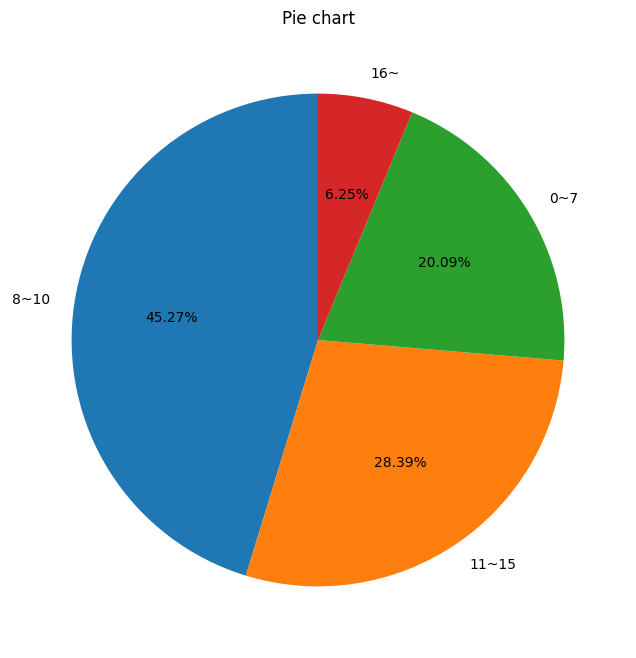

In [3]:
# Use the recommend multiclass classifier
def multi_class(x):
    if x <= 7:
        return 0
    elif x <= 10:
        return 1
    elif x <= 15:
        return 2
    else:
        return 3
class_dict = {0: '0~7', 1: '8~10', 2: '11~15', 3: '16~'}
# Use different number to map the value of ring-age
y = df.iloc[:, -1].map(multi_class)
X = df.iloc[:, :-1]
# 对性别进行映射
X['sex'] = X['sex'].map({'M': 0, 'F': 1, 'I': 3})
# 这里用的是老师的方法分类,并不均匀
print(y.value_counts())
plt.figure(figsize=(8, 8))
plt.pie(y.value_counts(), autopct='%.2f%%',
        startangle=90, labels=[class_dict[s] for s in y.value_counts().index])
plt.title('Pie chart')
plt.show()

In [4]:
# 还可以使用分桶的操作，来保证分布均匀的问题
#bins_1 可以让每个去区间的分布数量尽量平均
bins_1 = pd.qcut(df.iloc[:, -1], q=4)
print(bins_1.value_counts())
# bins_2 让数值区间相同
bins_2 = pd.cut(df.iloc[:, -1], bins=4)
print(bins_2.value_counts())

rings
(0.999, 8.0]    1407
(9.0, 11.0]     1121
(11.0, 29.0]     960
(8.0, 9.0]       689
Name: count, dtype: int64
rings
(8.0, 15.0]     2509
(0.972, 8.0]    1407
(15.0, 22.0]     245
(22.0, 29.0]      16
Name: count, dtype: int64


In [5]:
# 由于数据是处理过的，不需要再去做额外的特征工程
# 由于是多分类，我们可以使用One-to-one或者One-to-rest的方式
# 同时引入K折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def simple_nn_train(model, X=X, y=y, iter=30):
    ovo = []
    ovr = []
    for stra in ['ovo', 'ovr']:
        f1_socre_list = []
        roc_auc_score_list = []
        for i in range(1, iter + 1):
            f1_res = []
            roc_auc_res = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)
                f1 = f1_score(y_test, y_pred, average='micro')
                roc_auc = roc_auc_score(y_test, y_prob, multi_class=stra)
                f1_res.append(f1)
                roc_auc_res.append(roc_auc)
            f1_res_mean = np.mean(f1_res)
            roc_auc_res_mean = np.mean(roc_auc_res)
            if i % (iter / 10) == 0:
                print(
                    f'Iteration {i}/ {iter}: Using Stragety {stra} f1_score={f1_res_mean:.3f}; roc_auc={roc_auc_res_mean:.3f}')
            f1_socre_list.append(f1_res_mean)
            roc_auc_score_list.append(roc_auc_res_mean)
        print(
            f'Final Summary: Iterations {iter}, Stragety {stra}, f1_score={f1_socre_list[-1]:.3f}, roc_auc={roc_auc_score_list[-1]:.3f}')
        if stra == 'ovo':
            ovo.append(f1_socre_list)
            ovo.append(roc_auc_score_list)
        else:
            ovr.append(f1_socre_list)
            ovr.append(roc_auc_score_list)
    return ovo, ovr

In [6]:
iters = 100
print('Default Configuration')
default_ovo, default_ovr = simple_nn_train(MLPClassifier(warm_start=True, early_stopping=True), iter=iters)
print('Using solver=adam')
adam_ovo, adam_ovr = simple_nn_train(MLPClassifier(solver='adam', warm_start=True, early_stopping=True), iter=iters)

Default Configuration
Iteration 10/ 100: Using Stragety ovo f1_score=0.634; roc_auc=0.843
Iteration 20/ 100: Using Stragety ovo f1_score=0.642; roc_auc=0.851
Iteration 30/ 100: Using Stragety ovo f1_score=0.639; roc_auc=0.853
Iteration 40/ 100: Using Stragety ovo f1_score=0.643; roc_auc=0.855
Iteration 50/ 100: Using Stragety ovo f1_score=0.646; roc_auc=0.858
Iteration 60/ 100: Using Stragety ovo f1_score=0.650; roc_auc=0.860
Iteration 70/ 100: Using Stragety ovo f1_score=0.647; roc_auc=0.860
Iteration 80/ 100: Using Stragety ovo f1_score=0.652; roc_auc=0.860
Iteration 90/ 100: Using Stragety ovo f1_score=0.651; roc_auc=0.862
Iteration 100/ 100: Using Stragety ovo f1_score=0.652; roc_auc=0.862
Final Summary: Iterations 100, Stragety ovo, f1_score=0.652, roc_auc=0.862
Iteration 10/ 100: Using Stragety ovr f1_score=0.654; roc_auc=0.867
Iteration 20/ 100: Using Stragety ovr f1_score=0.655; roc_auc=0.867
Iteration 30/ 100: Using Stragety ovr f1_score=0.658; roc_auc=0.867
Iteration 40/ 100:

In [7]:
# 绘制收敛速度的曲线
# 封装绘制图片的函数
def plot_scores(tag='Default', iters=iters, data=None, score='f1_score'):
    if score == 'f1_score': d = 0
    else: d = 1
    plt.plot(range(1, iters + 1), data[d], label=tag)

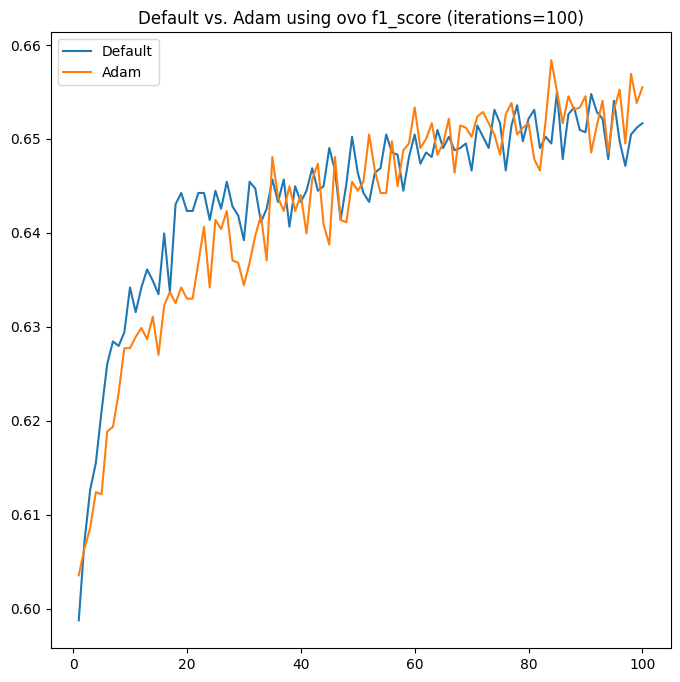

In [8]:
plt.figure(figsize=(8, 8))
plot_scores(tag='Default', data=default_ovo, score='f1_score')
plot_scores(tag='Adam', data=adam_ovo, score='f1_score')
plt.title(f'Default vs. Adam using ovo f1_score (iterations={iters})')
plt.legend()
plt.show()

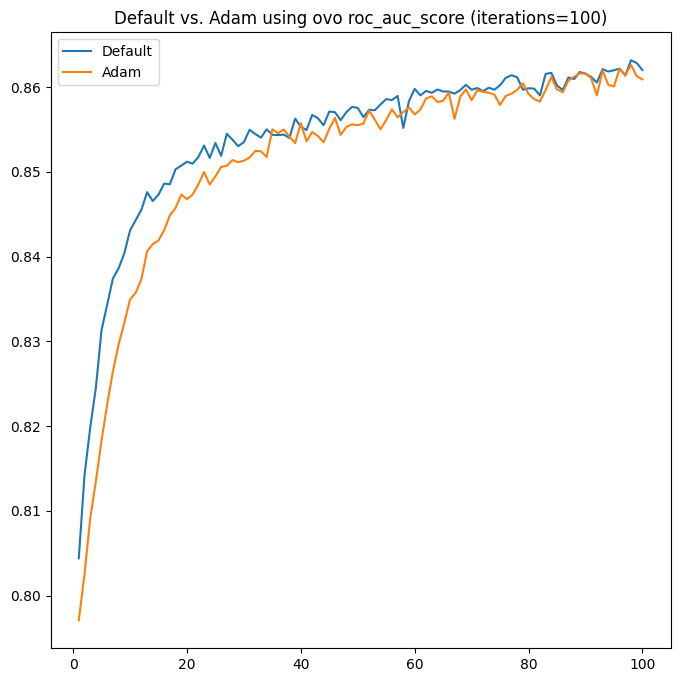

In [9]:
plt.figure(figsize=(8, 8))
plot_scores(tag='Default', data=default_ovo, score='roc_auc_score')
plot_scores(tag='Adam', data=adam_ovo, score='roc_auc_score')
plt.title(f'Default vs. Adam using ovo roc_auc_score (iterations={iters})')
plt.legend()
plt.show()
# 由于ovr表现不稳定没法体现Adam的优势，所以不画图

In [113]:
# 由于后面需要使用到dropout的技巧，这里就需要调用pytorch里面的神经网络了
# 先构建一个使用Adam作为优化器并且添加了L2的神经网络
class SGD(nn.Module):
    def __init__(self):
        super(SGD, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 4)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [89]:
# 处理数据
X_tensor, y_tensor = torch.tensor(X.values), torch.tensor(y.values)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [109]:

epoches = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

def train_eval(model, device, train_loader, val_loader, epoches, lr=0.001, weight_decay=0, verbose=True):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    finally_loss = 0
    finally_acc = 0
    for epoch in range(epoches):
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0 and verbose:
            print('Epoch:', epoch, 'Loss:', loss.item())
        finally_loss = loss.item()
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if epoch % 10 == 0 and verbose:
            print('Epoch:', epoch, 'Accuracy:', correct / total)
        finally_acc = correct / total
    print(f'Final Summary: loss {finally_loss:.5f}; Accuracy {finally_acc:.5f}')

In [114]:
train_eval(SGD(), device, train_loader, val_loader=val_loader, epoches=epoches)

Epoch: 0 Loss: 1.2964200973510742
Epoch: 0 Accuracy: 0.4649122807017544
Epoch: 10 Loss: 1.018652319908142
Epoch: 10 Accuracy: 0.6244019138755981
Epoch: 20 Loss: 1.0961169004440308
Epoch: 20 Accuracy: 0.6228070175438597
Epoch: 30 Loss: 1.1833926439285278
Epoch: 30 Accuracy: 0.6283891547049442
Epoch: 40 Loss: 1.1120562553405762
Epoch: 40 Accuracy: 0.6379585326953748
Epoch: 50 Loss: 1.0777472257614136
Epoch: 50 Accuracy: 0.645933014354067
Epoch: 60 Loss: 1.0851541757583618
Epoch: 60 Accuracy: 0.6467304625199362
Epoch: 70 Loss: 1.1604410409927368
Epoch: 70 Accuracy: 0.6419457735247209
Epoch: 80 Loss: 0.974940299987793
Epoch: 80 Accuracy: 0.6515151515151515
Epoch: 90 Loss: 1.0865691900253296
Epoch: 90 Accuracy: 0.6586921850079744
Final Summary: loss 1.11462; Accuracy 0.64035


In [86]:
# 引入Dropout
class SGDDropout(nn.Module):
    def __init__(self, dropout=0.5):
        super(SGDDropout, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.drop = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(64, 4)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [104]:
train_eval(SGDDropout(), device, train_loader, val_loader=val_loader, epoches=epoches)

Epoch: 0 Loss: 1.410864233970642
Epoch: 0 Accuracy: 0.4649122807017544
Epoch: 10 Loss: 1.1898704767227173
Epoch: 10 Accuracy: 0.6156299840510366
Epoch: 20 Loss: 1.1380650997161865
Epoch: 20 Accuracy: 0.6220095693779905
Epoch: 30 Loss: 1.222326397895813
Epoch: 30 Accuracy: 0.6275917065390749
Epoch: 40 Loss: 1.1969205141067505
Epoch: 40 Accuracy: 0.638755980861244
Epoch: 50 Loss: 1.1545984745025635
Epoch: 50 Accuracy: 0.6507177033492823
Epoch: 60 Loss: 1.2312146425247192
Epoch: 60 Accuracy: 0.6515151515151515
Epoch: 70 Loss: 1.0906016826629639
Epoch: 70 Accuracy: 0.6547049441786283
Epoch: 80 Loss: 1.113053798675537
Epoch: 80 Accuracy: 0.6602870813397129
Epoch: 90 Loss: 1.162558674812317
Epoch: 90 Accuracy: 0.6570972886762361
Final Summary: loss 1.162558674812317; Accuracy 0.6570972886762361


In [112]:
# 加入l2正则化
train_eval(SGD(), device=device, train_loader=train_loader, val_loader=val_loader, epoches=100, weight_decay=0.001)

Epoch: 0 Loss: 1.3332878351211548
Epoch: 0 Accuracy: 0.4649122807017544
Epoch: 10 Loss: 1.1706949472427368
Epoch: 10 Accuracy: 0.6092503987240829
Epoch: 20 Loss: 1.1559255123138428
Epoch: 20 Accuracy: 0.6052631578947368
Epoch: 30 Loss: 1.1836177110671997
Epoch: 30 Accuracy: 0.6108452950558214
Epoch: 40 Loss: 1.1665328741073608
Epoch: 40 Accuracy: 0.6172248803827751
Epoch: 50 Loss: 1.1786823272705078
Epoch: 50 Accuracy: 0.6156299840510366
Epoch: 60 Loss: 1.1768214702606201
Epoch: 60 Accuracy: 0.6212121212121212
Epoch: 70 Loss: 1.2332520484924316
Epoch: 70 Accuracy: 0.6212121212121212
Epoch: 80 Loss: 1.197862982749939
Epoch: 80 Accuracy: 0.6196172248803827
Epoch: 90 Loss: 1.0973045825958252
Epoch: 90 Accuracy: 0.6188197767145136
Final Summary: loss 1.17715; Accuracy 0.61962


In [100]:
# 尝试不同的combination来测试
dropouts = [0.4, 0.5, 0.6, 0.7]
weight_decays = [1e-2, 1e-3, 5e-3, 5e-4]


In [110]:
for d_rate in dropouts:
    print(f'Dropout: {d_rate}')
    train_eval(SGDDropout(d_rate), device, train_loader, val_loader=val_loader, epoches=epoches, verbose=False)
for w_decay in weight_decays:
    print(f'Weight decay: {w_decay}')
    train_eval(SGD(), device, train_loader, val_loader=val_loader, epoches=epoches, weight_decay=w_decay, verbose=False)

Dropout: 0.4
Final Summary: loss 1.18047; Accuracy 0.65710
Dropout: 0.5
Final Summary: loss 1.12273; Accuracy 0.65550
Dropout: 0.6
Final Summary: loss 1.15580; Accuracy 0.63636
Dropout: 0.7
Final Summary: loss 1.03931; Accuracy 0.65470
Weight decay: 0.01
Final Summary: loss 1.18705; Accuracy 0.60526
Weight decay: 0.001
Final Summary: loss 1.02910; Accuracy 0.66108
Weight decay: 0.005
Final Summary: loss 1.14694; Accuracy 0.61722
Weight decay: 0.0005
Final Summary: loss 1.08092; Accuracy 0.64753
